# Twitter Sentiment Analysis: 
## US Election Results

### Imports

In [2]:
from twython import Twython
from twython import TwythonStreamer
import ujson #for ease, convert back to json
import sys
from pprint import pprint
import time
import random
from requests.exceptions import ChunkedEncodingError
import pickle
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import nltk
from wordcloud import WordCloud, STOPWORDS
import string
from textblob import TextBlob
from nltk.stem.lancaster import LancasterStemmer
import glob
import os
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.manifold import MDS
import scipy.stats as stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import decomposition
from nltk.stem.porter import PorterStemmer

## Twitter Credentials

In [3]:
with open('twitter_credentials.json', 'r') as c:
    credentials = ujson.load(c)

CONSUMER_KEY = credentials['CONSUMER_KEY']
CONSUMER_SECRET = credentials['CONSUMER_SECRET']
ACCESS_TOKEN = credentials['ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = credentials['ACCESS_TOKEN_SECRET']

## Twitter Locations

In [4]:
#Using Airport Codes as keys for locations
tweet_locations = {
    'dfw': "-97.48,32.31,-96.49,33.26,",
    'jfk': "-74,40,-73,41",
    'sfo': "-122.75,36.8,-121.75,37.8",
    'lax': "-118.43,33.73,-117.93,34.21",
    'ord': "-88.47,41.46,-87.16,42.35",
    'dca': "-77.26,38.73,-76.87,39.10",
    'atl': "-84.54,33.62,-84.18,33.96"
}

## Download Streams of Tweets

In [4]:
#tweet_text = pickle.load(open('pickle_text_obama.pickle','r'))
tweet_text = []

class MyStreamer(TwythonStreamer):
    def on_success(self, data):
        try:
            if data['lang'] == 'en':
                tweet_text.append(unidecode(data['text']))
        except: print 'skipped error'
            
        if len(tweet_text) >= 10000:
            self.disconnect()

    def on_error(self, status_code, data):
        print status_code, data
        self.disconnect()

##########################
### implement download ###
##########################
keyword = 'hillary'
stream = MyStreamer(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

while len(tweet_text)<=10000:
    try:
        stream.statuses.filter(track=keyword,locations=bounds)        
    except: 
        continue

with open('pickle_text_{}.pickle'.format(keyword),'w') as m:
    pickle.dump(tweet_text,m)

In [ ]:
#tweet_text = pickle.load(open('pickle_text_obama_dfw.pickle','r'))
tweet_text = []

class MyStreamer(TwythonStreamer):
    def on_success(self, data):
        try:
            if data['lang'] == 'en':
                print(data['text'])
                if keyword in unidecode(data['text']) or unicode(keyword) in data['text']:
                    tweet_text.append(unidecode(data['text']))
        except: print 'skipped error'
            
        if len(tweet_text) >= 10000:
            self.disconnect()

    def on_error(self, status_code, data):
        print status_code, data
        self.disconnect()

##########################
### implement download ###
##########################
keyword = 'trump'
location = 'jfk'
bounds = tweet_locations[location]
stream = MyStreamer(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

while len(tweet_text)<=10000:
    try:
        stream.statuses.filter(locations=bounds)        
    except: 
        continue
print(tweet_text)
#with open('pickle_text_{}_{}.pickle'.format(keyword,location),'w') as m:
#    pickle.dump(tweet_text,m)

In [14]:
print(tweet_text)
print('*'*75)

def cleanTweets(orig_tweets):
    p = string.punctuation
    table_p = string.maketrans(p, len(p) * " ")
    stopwords = nltk.corpus.stopwords.words('english')
    ps = PorterStemmer()
    twitter_words = [u'http',u'https',u'RT',u'co','http','https','co','RT','amp',u'amp','&amp']
    return_tweets = []
    
    for tweet in orig_tweets:
        temp_tweet = tweet.translate(table_p)
        temp_list = tweet.strip().split()
        tweet_keep = ''
        for word in temp_list:
            if word not in stopwords:
                if word not in twitter_words:
                    tweet_keep = tweet_keep+ps.stem(str(word))+' '
        return_tweets.append(tweet_keep)       
    return return_tweets   

print(cleanTweets(tweet_text)) 

['RT @HillaryClinton: "We have seen that our nation is more deeply divided than we thought. But I still believe in America--and I always will....', "RT @aravosis: Peter is absolutely right. It's hardly Hillary's fault if some couldn't figure out that Trump is dangerous. What mo... ", 'RT @CounterMoonbat: BREAKING: Cabinet official who set up a homebrew server to sidestep transparency upset the FBI looked into it. https://...', 'RT @DJ_Lena: Yo. Super delegates. \nYeah, you!\nThanks for Trump. \nhttps://t.co/JYvW8KjOnC https://t.co/Ze3itKaI9l', '@igorvolsky hiya hun,do u have anything to say about Hillary Clinton endorsing former KKK member Robert Byrd? https://t.co/lUa52XO6ug', "The Right keeps telling us their conservative economic plan will fix our problems if we just try it, you'd think it'd have helped by now", 'RT @MacBethSpeaks: Hillary &amp; her cabal love the victim role. Humanity sees she\'s the common denominator in all the "conspiracies" b/c... ', 'Aint this what the Republi

## Process Tweets (Functions Only/No Calls)

In [4]:
def build_cloud(text, image_path, out_path):
    p = string.punctuation
    table_p = string.maketrans(p, len(p) * " ")
    stopwords = nltk.corpus.stopwords.words('english')
    ls = LancasterStemmer()
    good_text = ' '
    for word in text:
        if word not in stopwords:
            good_text+=(ls.stem(str(word).lower())+' ')
    
    good_text = good_text.translate(table_p)
    
    twitter_words = [u'http',u'https',u'rt',u'co','http','https','co','rt','amp',u'amp']
    
    for word in twitter_words:
        good_text=good_text.replace(word,'')
    
    d = path.dirname('__file__')
    
    my_mask = np.array(Image.open(path.join(d, image_path)))
    
    wc = WordCloud(background_color="white",max_words=2000, mask=my_mask, stopwords = STOPWORDS)
    
    wc.generate(good_text)
    
    wc.to_file(path.join(d,out_path))
    
    plt.imshow(wc)
    plt.axis("off")
    #plt.figure()
    #plt.imshow(my_mask, cmap=plt.cm.gray)
    #plt.axis("off")
    plt.show()

def get_sentiment(text):
    p = string.punctuation
    table_p = string.maketrans(p, len(p) * " ")
    stopwords = nltk.corpus.stopwords.words('english')
    ls = LancasterStemmer()
    good_text = ' '
    
    if type(text) is str:
        text = text.translate(table_p)
        text = text.lower().strip().split()
    
    for word in text:
        if word not in stopwords:
            good_text+=(ls.stem(str(word).lower())+' ')
    
    return(TextBlob(good_text).sentiment)
    
        

## Implement the Processing Functions

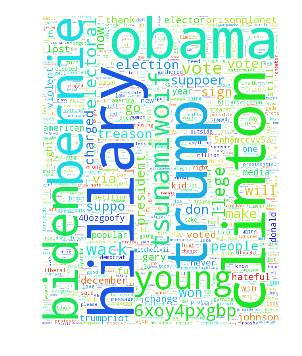

Total Sentiment
Sentiment(polarity=0.05585756737989976, subjectivity=0.5149454175400889)
Average Polarity: 
0.108129889512
Average Subjectivity: 
0.324119271454


In [19]:
p = string.punctuation
table_p = string.maketrans(p, len(p) * " ")
subject = "hillary"
location = "atl"

if location is None:
    the_tweets = pickle.load(open('pickle_text_{}.pickle'.format(subject),'r'))
else:
    the_tweets = pickle.load(open('pickle_text_{}_{}.pickle'.format(subject,location),'r'))

the_words = []

for tweet in the_tweets:
    the_words.append(tweet.translate(table_p).lower().strip().split())

build_cloud(the_words, '{}.png'.format(subject), 'WordCloud_{}_{}.png'.format(subject,location))


print("Total Sentiment")
print(get_sentiment(the_words))


polarity_array = np.array([])
subjectivity_array = np.array([])

for tweet in the_tweets:
    polarity = get_sentiment(tweet)[0]
    subjectivity = get_sentiment(tweet)[1]
    polarity_array = np.append(polarity_array, polarity)
    subjectivity_array = np.append(subjectivity_array, subjectivity)

#print(np.size(polarity_array))
#print(np.size(subjectivity_array))
print("Average Polarity: ")
print(np.average(polarity_array))
print("Average Subjectivity: ")
print(np.average(subjectivity_array))

#########################################
# Interpretation:
# Polarity: -1 to 1 positve/negative
# subjectivity: 0 - 1
#   1 = Subjective (emotional)
#   2 = Objective (factual)

# Topic Analysis

## Generate Master Tweet Corpus for Topic Analysis

In [45]:
obama_tweets = pickle.load(open('pickle_text_obama.pickle','r'))
trump_tweets = pickle.load(open('pickle_text_trump.pickle','r'))
hillary_tweets = pickle.load(open('pickle_text_hillary.pickle','r'))
master_tweets = obama_tweets + trump_tweets + hillary_tweets
with open('pickle_all_text.pickle','w') as p:
    pickle.dump(master_tweets,p)

## NMF

In [4]:
def my_NMF(my_pickle, topic_count):
    corpus = pickle.load(open(my_pickle,'r'))

    vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
    dtm = vectorizer.fit_transform(corpus)
    vocab = vectorizer.get_feature_names() 

    print('(Count Docs, Count Words)') 
    print(dtm.shape) 

    num_topics = topic_count

    clf = decomposition.NMF(n_components=num_topics, random_state=1)
    doctopic = clf.fit_transform(dtm)
    print('(Number of Topics, CLF Reconstruction Error)') 
    print(num_topics, clf.reconstruction_err_) 

    topic_words = []
    num_top_words = 7
    for topic in clf.components_:
        #print topic.shape, topic[:5]
        word_idx = np.argsort(topic)[::-1][0:num_top_words] # get indexes with highest weights
        #print 'top indexes', word_idx
        topic_words.append([vocab[i] for i in word_idx])
        #print topic_words[-1]
        #print

    print('*' * 75)    


    for t in range(len(topic_words)):
        print("Topic {}: {}".format(t+1, ' '.join(topic_words[t][:15])))

my_NMF('pickle_all_text.pickle',10)

(Count Docs, Count Words)
(33003, 12706)
(Number of Topics, CLF Reconstruction Error)
50 159.846418096
***************************************************************************
Topic 1: jus1nyt tgtlh8x1ul biden president obama trump https
Topic 2: 59 votes elected donald 085 236 903
Topic 3: salute water plane ny takes given foxnews
Topic 4: https rt crushing landslide numbers delete video
Topic 5: protester calls address cool violence die kellyannepolls
Topic 6: tape caught beating national story voter brutally
Topic 7: gratitude owes enormous debt dete graceful country
Topic 8: hillary clinton named wants don_vito_08 neverclintons lost
Topic 9: pardon giuliani rudy think foxandfriends don determine
Topic 10: beliefs hated palmchanel hate black obama trump
Topic 11: white house welcome nufanglenesse cxb54v9x1s staff watching
Topic 12: going chance lead owe open mind hillaryclinton
Topic 13: amp comey blamed doing stop ed cried
Topic 14: lose hobby iamkris24 40 picked politics buildi

## LDA

In [2]:
from __future__ import division, print_function
from gensim import corpora, models, similarities, matutils
import re
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO 

C:\Users\ajwil\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
def my_LDA(my_pickle, num_topics):
    ascii_docs = pickle.load(open(my_pickle,'r'))
    docs = []
    for d in ascii_docs:
        docs.append(d.strip().split())

    dic = corpora.Dictionary(docs)
    print(dic)
    
    corpus = [dic.doc2bow(text) for text in docs]
    print(type(corpus), len(corpus))
    
    tfidf = models.TfidfModel(corpus)
    print(type(tfidf))
    
    corpus_tfidf = tfidf[corpus]
    print(type(corpus_tfidf))
    
    NUM_TOPICS = num_topics
    model = models.ldamodel.LdaModel(corpus_tfidf, num_topics=NUM_TOPICS, 
                                     id2word=dic, 
                                     update_every=1, 
                                     passes=25)
    
    print("LDA model")
    topics_found = model.print_topics(20)
    counter = 1
    for t in topics_found:
        print("Topic #{} {}".format(counter, t))
        counter += 1
my_LDA('pickle_all_text.pickle',10)

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(17584 unique tokens: [u'Antal', u'manufacturing', u'#TrumpPence16', u'mustachio', u'ye...']...)
INFO : adding document #20000 to Dictionary(37769 unique tokens: [u'#TrumpPence16', u'ready!"', u'mustachio', u'deferment', u'FAIRNESS']...)
INFO : adding document #30000 to Dictionary(51361 unique tokens: [u'hjw(Hillary', u'#TrumpPence16', u'ready!"', u'mustachio', u'deferment']...)
INFO : built Dictionary(54363 unique tokens: [u'hjw(Hillary', u'#TrumpPence16', u'ready!"', u'mustachio', u'deferment']...) from 33003 documents (total 583839 corpus positions)


Dictionary(54363 unique tokens: [u'hjw(Hillary', u'#TrumpPence16', u'ready!"', u'mustachio', u'deferment']...)


INFO : collecting document frequencies
INFO : PROGRESS: processing document #0
INFO : PROGRESS: processing document #10000
INFO : PROGRESS: processing document #20000
INFO : PROGRESS: processing document #30000
INFO : calculating IDF weights for 33003 documents and 54362 features (558988 matrix non-zeros)
INFO : using symmetric alpha at 0.02
INFO : using symmetric eta at 0.02
INFO : using serial LDA version on this node


<type 'list'> 33003
<class 'gensim.models.tfidfmodel.TfidfModel'>
<class 'gensim.interfaces.TransformedCorpus'>


INFO : running online LDA training, 50 topics, 25 passes over the supplied corpus of 33003 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #2000/33003
INFO : merging changes from 2000 documents into a model of 33003 documents
INFO : topic #7 (0.020): 0.007*"Obama" + 0.007*"next" + 0.007*"White" + 0.007*"welcome" + 0.007*"the" + 0.006*"staff" + 0.006*"president." + 0.006*"watching" + 0.006*"as" + 0.006*"@Nufanglenesse:"
INFO : topic #36 (0.020): 0.012*"Obama" + 0.006*"2020" + 0.005*"great" + 0.005*"Michelle" + 0.004*""I" + 0.004*"than" + 0.004*"be" + 0.004*"@TmarTn:" + 0.004*"https://t.co/BoRJoUfR9K" + 0.004*"#TheGoat"
INFO : topic #29 (0.020): 0.008*"Obama" + 0.006*"that" + 0.005*"President" + 0.005*"to" + 0.005*"cooperation" + 0.005*"@moshekasher:" + 0.005*"President..." + 0.005*"OBAMA" + 0.005*"we" + 0.004*"important"
INFO : topic #46 (0.020): 

LDA model
Topic #1 (12, u'0.032*"https:..." + 0.024*"Clinton." + 0.015*"USA" + 0.014*"you\'re" + 0.013*"Crushing" + 0.013*"Landslide" + 0.013*"Numbers" + 0.010*"level" + 0.009*"much" + 0.008*"see"')
Topic #2 (19, u'0.034*"\'People" + 0.031*"Have" + 0.030*"Calls" + 0.030*"Violence" + 0.030*"Die\':" + 0.030*"Protester" + 0.030*"address." + 0.030*"cool." + 0.029*"should" + 0.028*"@KellyannePolls:"')
Topic #3 (48, u'0.041*"CNN" + 0.031*"Hillary\'s" + 0.011*"Please" + 0.010*"needs" + 0.010*"look" + 0.009*"seen" + 0.009*"future" + 0.009*"believe" + 0.008*"Russia" + 0.008*"that\'s"')
Topic #4 (2, u'0.009*"power" + 0.008*"elect" + 0.008*"war" + 0.007*"An" + 0.007*"Will" + 0.006*"Blame" + 0.006*"being" + 0.006*"women," + 0.006*"it," + 0.005*"racist,"')
Topic #5 (10, u'0.088*"elected" + 0.030*"story." + 0.027*"country" + 0.021*"hillary" + 0.018*"people" + 0.011*"Clinton" + 0.010*"anyone" + 0.009*"one" + 0.009*"Hillary" + 0.009*"find"')
Topic #6 (43, u'0.037*"OF" + 0.029*"HILLARY" + 0.022*"what\'